In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
keras = tf.keras
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker

from dh_data import generate_jump_diffusion_data
from dh_framework import build_dh_model
from dh_loss_functions import VaR, CVaR, entropic
from dh_experiments import set_global_seed, BlackScholesPrice

# Set seed for reproducibility
set_global_seed(42)

/Users/rugile/Pricing and Hedging Using Neural Networks/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Generate Jump Diffusion Data
price_paths, payoffs = generate_jump_diffusion_data(
    jump_int=7,
    mu_jump=0.75,
    sigma_jump=0.01,
    N=10**5,
    sigma = 0.2,
    d=1,
    n=100,
    K=1.0,
    T=1.0,
    S=1.0
)

# Verify Heavy Tails
from scipy.stats import kurtosis
k = kurtosis(price_paths[:,-1,0], fisher=False)
print("Kurtosis is ",k)

Kurtosis is  60.1111155724611


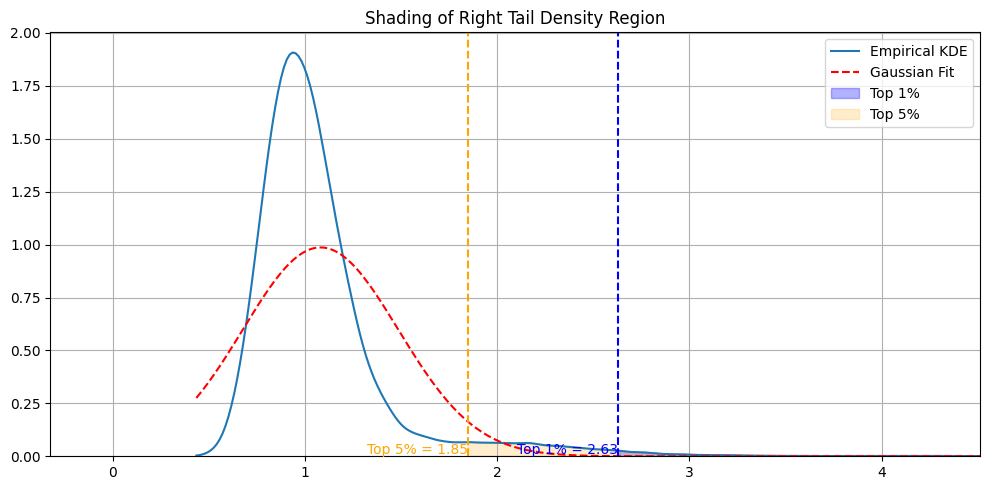

In [3]:
# View data
from scipy.stats import gaussian_kde, norm

# Use your terminal prices
terminal_prices = price_paths[:, -1, 0]

# Estimate density using KDE
kde = gaussian_kde(terminal_prices)
x_vals = np.linspace(min(terminal_prices), max(terminal_prices), 1000)
empirical_kde = kde(x_vals)

# Fit Gaussian for comparison
mu, std = np.mean(terminal_prices), np.std(terminal_prices)
gaussian_pdf = norm.pdf(x_vals, loc=mu, scale=std)

# Quantiles for shading
q95 = np.percentile(terminal_prices, 95)
q99 = np.percentile(terminal_prices, 99)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x_vals, empirical_kde, label='Empirical KDE')
ax.plot(x_vals, gaussian_pdf, 'r--', label='Gaussian Fit')

# Shaded regions beyond quantiles
ax.fill_between(x_vals, 0, empirical_kde, where=(x_vals >= q99), color='blue', alpha=0.3, label='Top 1%')
ax.fill_between(x_vals, 0, empirical_kde, where=(x_vals >= q95), color='orange', alpha=0.2, label='Top 5%')

# Vertical lines
ax.axvline(q99, color='blue', linestyle='--')
ax.axvline(q95, color='orange', linestyle='--')

# Annotate thresholds
ax.text(q99, 0.01, f'Top 1% = {q99:.2f}', color='blue', ha='right')
ax.text(q95, 0.01, f'Top 5% = {q95:.2f}', color='orange', ha='right')

# Final touches
ax.set_xlim(left=None, right=np.percentile(terminal_prices, 99.9))
ax.set_ylim(bottom=0)
ax.set_title("Shading of Right Tail Density Region")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Split data into training and testing data
xtrain, xtest, ytrain, ytest = train_test_split(
    price_paths, payoffs,
    test_size = 0.2,        # 20% of data is used for testing
    random_state = 42,
    shuffle = True
)

# Initialize lists
losses = ['mse', VaR(alpha=0.05), CVaR(alpha=0.05), entropic(beta = 3)]
titles = ['MSE', 'VaR', 'CVaR', 'Entropic']

# Define the learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.005,
    decay_steps = 1000,
    decay_rate = 0.96,
    staircase = True
)

# Define an early stop
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

# Grid search values
L_values = [3, 4, 5]
n_hidden_values = [16, 32, 64]


Training MSE_L3_N16

Training MSE_L3_N32

Training MSE_L3_N64

Training MSE_L4_N16

Training MSE_L4_N32

Training MSE_L4_N64

Training MSE_L5_N16

Training MSE_L5_N32

Training MSE_L5_N64

Training VaR_L3_N16

Training VaR_L3_N32

Training VaR_L3_N64

Training VaR_L4_N16

Training VaR_L4_N32

Training VaR_L4_N64

Training VaR_L5_N16

Training VaR_L5_N32

Training VaR_L5_N64

Training CVaR_L3_N16

Training CVaR_L3_N32

Training CVaR_L3_N64

Training CVaR_L4_N16

Training CVaR_L4_N32

Training CVaR_L4_N64

Training CVaR_L5_N16

Training CVaR_L5_N32

Training CVaR_L5_N64

Training Entropic_L3_N16

Training Entropic_L3_N32

Training Entropic_L3_N64

Training Entropic_L4_N16

Training Entropic_L4_N32

Training Entropic_L4_N64

Training Entropic_L5_N16

Training Entropic_L5_N32

Training Entropic_L5_N64


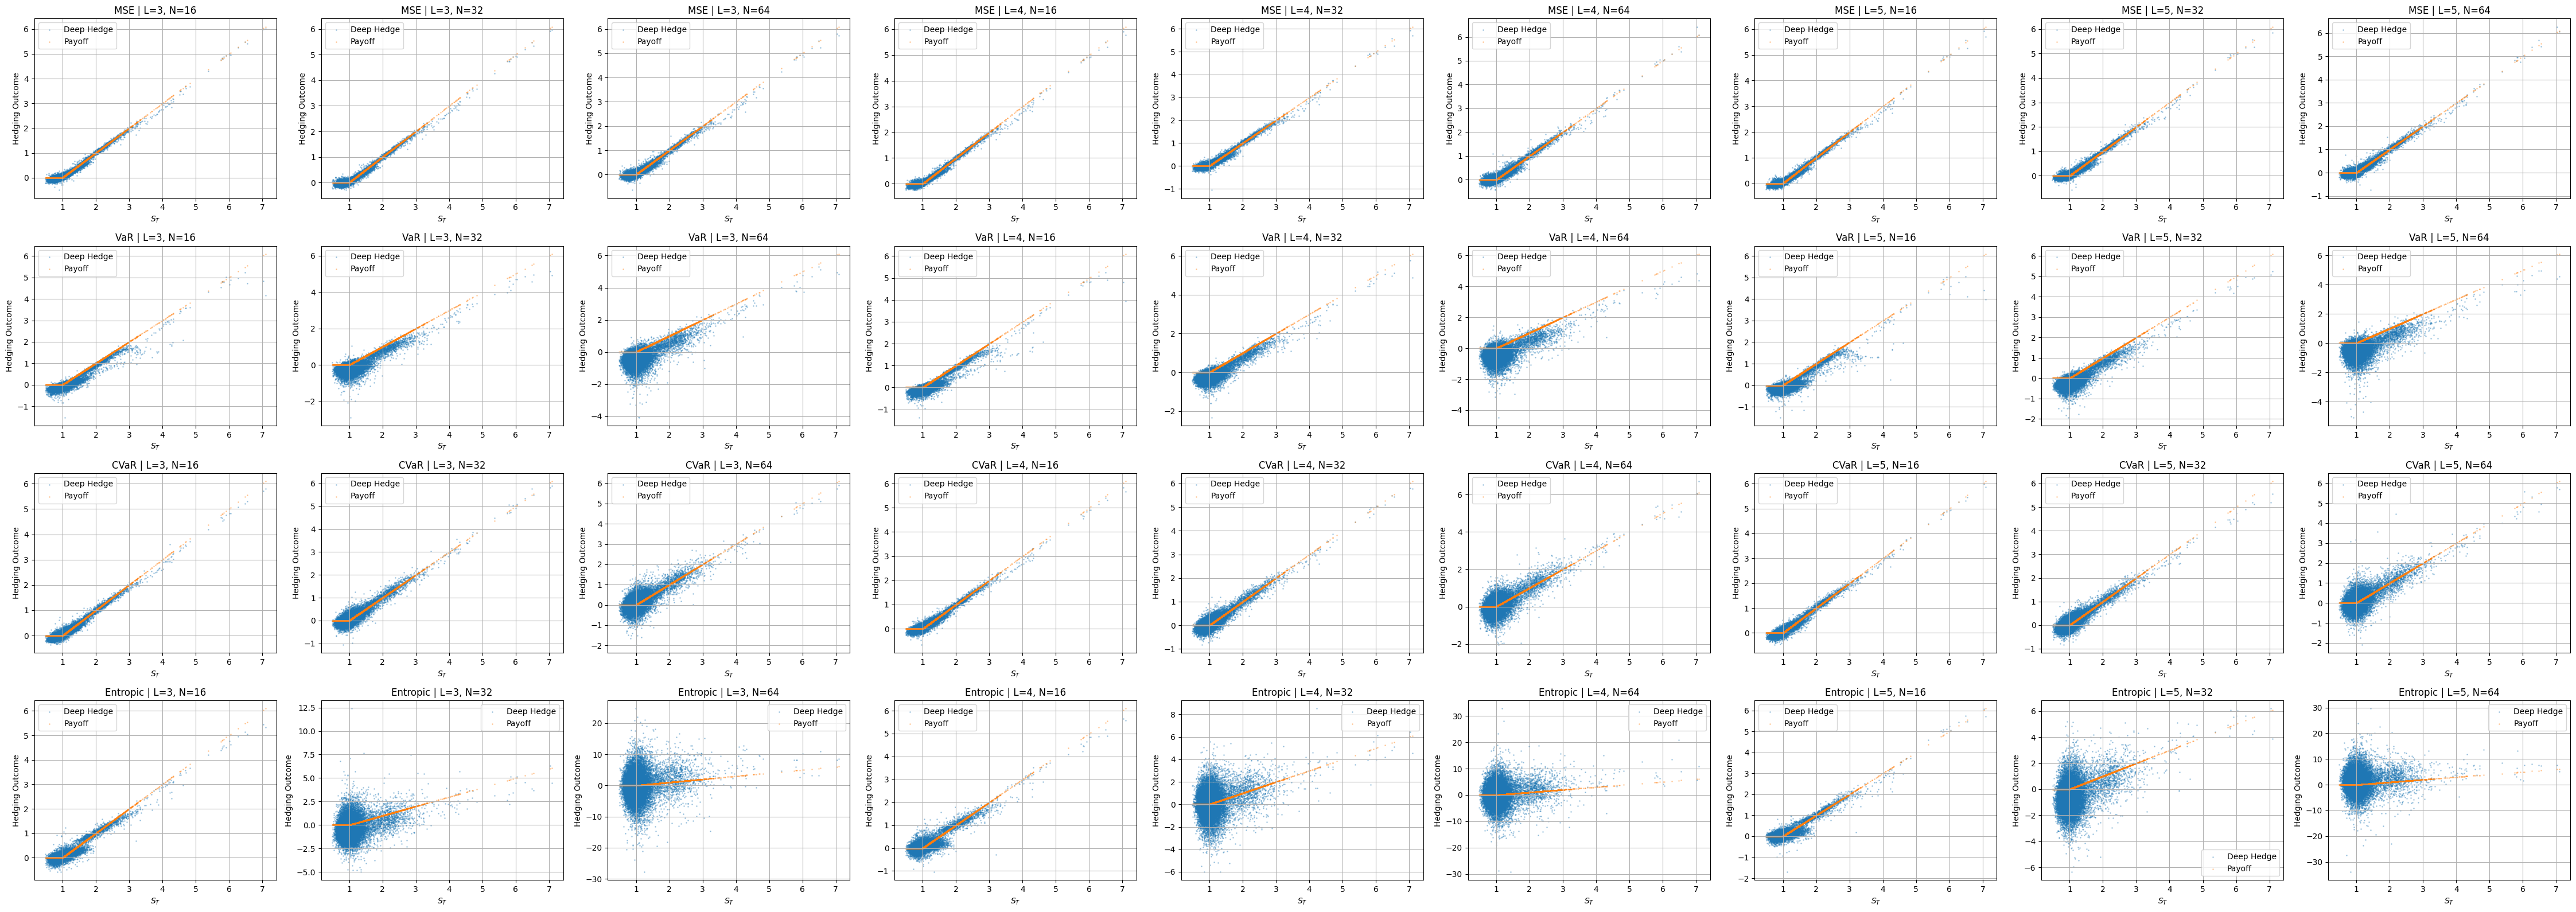


---- Premiums ----
MSE_L3_N16           Premium: 0.098943 | Error: 0.019683
MSE_L3_N32           Premium: 0.083104 | Error: 0.003844
MSE_L3_N64           Premium: 0.093962 | Error: 0.014703
MSE_L4_N16           Premium: 0.095346 | Error: 0.016086
MSE_L4_N32           Premium: 0.094433 | Error: 0.015173
MSE_L4_N64           Premium: -0.003893 | Error: -0.083152
MSE_L5_N16           Premium: 0.092743 | Error: 0.013483
MSE_L5_N32           Premium: 0.110891 | Error: 0.031631
MSE_L5_N64           Premium: 0.060638 | Error: -0.018621
VaR_L3_N16           Premium: -0.000450 | Error: -0.079709
VaR_L3_N32           Premium: -0.039027 | Error: -0.118287
VaR_L3_N64           Premium: -0.168410 | Error: -0.247670
VaR_L4_N16           Premium: -0.013247 | Error: -0.092506
VaR_L4_N32           Premium: -0.049567 | Error: -0.128827
VaR_L4_N64           Premium: -0.230108 | Error: -0.309368
VaR_L5_N16           Premium: -0.020602 | Error: -0.099862
VaR_L5_N32           Premium: -0.051304 | Error: -0

In [5]:
# Storage for results
results = {}

# Grid search loop
for i, lossfn in enumerate(losses):
    for L in L_values:
        for n_hidden in n_hidden_values:
            tf.keras.backend.clear_session()
            key = f"{titles[i]}_L{L}_N{n_hidden}"
            print(f"\nTraining {key}")

            model, Network0, Networks = build_dh_model(
                d=1, hidden_nodes=n_hidden, L=L, n=100
            )

            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=lossfn
            )

            start = tf.timestamp()
            history = model.fit(
                x=xtrain, y=ytrain,
                epochs=50,
                batch_size=1024,
                validation_split=0.1,
                callbacks=[early_stop],
                verbose=0
            )
            time = tf.timestamp() - start

            hedge = model.predict(xtest, verbose=0)
            premium = float(Network0(tf.ones([1, 1])).numpy().squeeze())

            results[key] = {
                "model": model,
                "hedge": hedge,
                "premium": premium,
                "time": float(time),
                "title": titles[i],
                "L": L,
                "n_hidden": n_hidden
            }

# === Plotting ===
n_rows = len(losses)
n_cols = len(L_values) * len(n_hidden_values)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)

for i, loss in enumerate(titles):
    for j, (L, n_hidden) in enumerate([(L, n) for L in L_values for n in n_hidden_values]):
        key = f"{loss}_L{L}_N{n_hidden}"
        ax = axes[i, j]
        ax.scatter(xtest[:, -1, 0], results[key]["hedge"][:, 0], s=1, alpha=0.3, label="Deep Hedge")
        ax.scatter(xtest[:, -1, 0], ytest[:, 0], s=1, alpha=0.3, label="Payoff")
        ax.set_title(f"{loss} | L={L}, N={n_hidden}")
        ax.set_xlabel("$S_T$")
        ax.set_ylabel("Hedging Outcome")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

# === Summary Output ===
BSPremium = BlackScholesPrice(T=1.0, S=1.0, K=1.0, sigma=0.2)

print("\n---- Premiums ----")
for key, val in results.items():
    print(f"{key:<20} Premium: {val['premium']:.6f} | Error: {val['premium'] - BSPremium:.6f}")

print("\n---- Training Times ----")
for key, val in results.items():
    print(f"{key:<20} Time: {val['time']:.2f} sec")

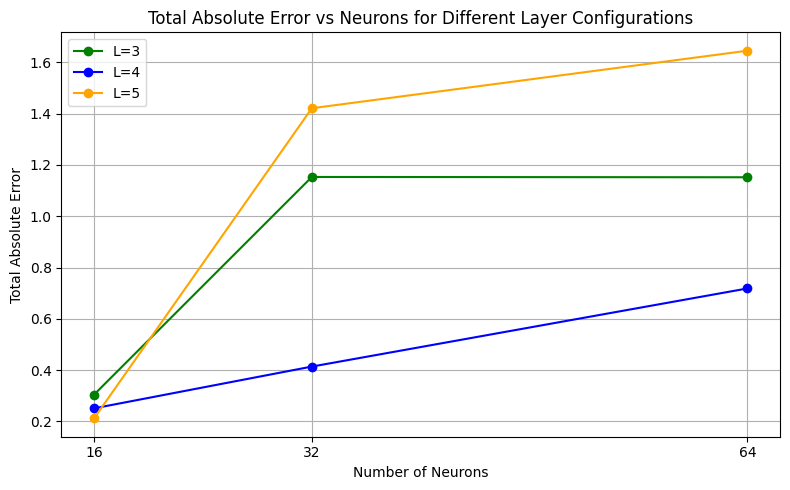

In [15]:
NVals = [16, 32, 64]
LVals = [3, 4, 5]

L3Errors = [0.304815, 1.153309, 1.152128]
L4Errors = [0.251265, 0.414082, 0.7186049999999999]
L5Errors = [0.212271, 1.421222, 1.645497]

plt.figure(figsize=(8, 5))
plt.plot(NVals, L3Errors, marker='o', color='green', label='L=3')
plt.plot(NVals, L4Errors, marker='o', color='blue', label='L=4')
plt.plot(NVals, L5Errors, marker='o', color='orange', label='L=5')

plt.xlabel('Number of Neurons')
plt.ylabel('Total Absolute Error')
plt.title('Total Absolute Error vs Neurons for Different Layer Configurations')

plt.xticks(NVals)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()